## Problem One: Confirmation of competition contents

**What to learn and what to predict?**
• To predict the chances of an applicant defaulting in loan repayment. 

**What kind of file to create and submit to Kaggle?**
• A file predicting the probability for the TARGET variable. It should contain a header of both SK_ID_CURR and TARGET  

**What kind of index value will be used to evaluate the submissions?**
• Submissions are evaluated based on the area under the ROC curve between the predicted probability and the target. The ROC-AUC (Receiver Operating Characteristic - Area Under the Curve) is a performance measurement for the classification problems at various threshold settings. It plots the true positive rate against the false positive rate for different decision thresholds. The higher the area under the curve (AUC), the better the model is at distinguishing between classes.

## Problem Two: Learning and verification

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder

In [2]:
# Loading the dataset
df_train = pd.read_csv("application_train.csv")
df_test = pd.read_csv("application_test.csv")

df_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
display(df_train.info())
display(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Columns: 121 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(40), object(16)
memory usage: 45.0+ MB


None

In [4]:
display(df_train.shape)
display(df_test.shape)

(307511, 122)

(48744, 121)

* The test dataset is missing the target column because target is the variable we're trying to predict.
* We have 16 columns of data type object

In [5]:
(df_train.isna().sum() > 0).value_counts()

True     67
False    55
dtype: int64

In [6]:
df_test.columns[(df_test.isna().sum() > 0)]

Index(['AMT_ANNUITY', 'NAME_TYPE_SUITE', 'OWN_CAR_AGE', 'OCCUPATION_TYPE',
       'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG',
       'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG',
       'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG',
       'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG',
       'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG',
       'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE',
       'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE',
       'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE',
       'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE',
       'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI',
       'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI',
       'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOORSMAX_MEDI', 'FLOORSMIN_MEDI',
       'LANDAREA_MEDI', 'LIVINGAPART

In [7]:
# Function to check the correlation between a quantitative variable and the target
def compare_corr(features):
    features.append("TARGET")
    return df_train[features].corr()


def compute_chi(cat_variable):
    """
    Function to compute the correlation of a categorical variable and the target
    """
    # Create a contingency table
    contingency_table = pd.crosstab(df_train[cat_variable], df_train["TARGET"])

    # Calculate the chi-square statistic and p-value
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    # Print the results
    print("Chi-square statistic:", chi2)
    print("p-value:", p)

In [8]:
# Getting the percentage of missing values in the train dataset

percent_missing_train = df_train.isna().sum() / len(df_train) * 100

col_missing_train = df_train.columns[(percent_missing_train != 0)]

percent_missing_train[percent_missing_train > 0].sort_values(ascending=False).tail(60)

LIVINGAPARTMENTS_MODE           68.354953
LIVINGAPARTMENTS_MEDI           68.354953
LIVINGAPARTMENTS_AVG            68.354953
FLOORSMIN_MODE                  67.848630
FLOORSMIN_MEDI                  67.848630
FLOORSMIN_AVG                   67.848630
YEARS_BUILD_MODE                66.497784
YEARS_BUILD_MEDI                66.497784
YEARS_BUILD_AVG                 66.497784
OWN_CAR_AGE                     65.990810
LANDAREA_AVG                    59.376738
LANDAREA_MEDI                   59.376738
LANDAREA_MODE                   59.376738
BASEMENTAREA_MEDI               58.515956
BASEMENTAREA_AVG                58.515956
BASEMENTAREA_MODE               58.515956
EXT_SOURCE_1                    56.381073
NONLIVINGAREA_MEDI              55.179164
NONLIVINGAREA_MODE              55.179164
NONLIVINGAREA_AVG               55.179164
ELEVATORS_MEDI                  53.295980
ELEVATORS_MODE                  53.295980
ELEVATORS_AVG                   53.295980
WALLSMATERIAL_MODE              50

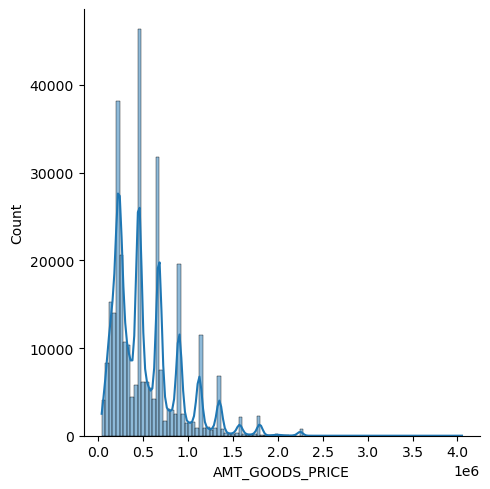

In [9]:
sns.displot(df_train["AMT_GOODS_PRICE"], kde=True, bins=100)

In [10]:
df_train["AMT_GOODS_PRICE"].fillna(df_train["AMT_GOODS_PRICE"].median(), inplace=True)
df_test["AMT_GOODS_PRICE"].fillna(df_test["AMT_GOODS_PRICE"].median(), inplace=True)

In [11]:
sns.displot(df_train["AMT_ANNUITY"], kde=True, bins=70)

In [12]:
df_train["AMT_ANNUITY"].fillna(df_train["AMT_ANNUITY"].median(), inplace=True)
df_test["AMT_ANNUITY"].fillna(df_test["AMT_ANNUITY"].median(), inplace=True)

In [13]:
sns.displot(df_train["CNT_FAM_MEMBERS"], kde=True)

In [14]:
df_train["CNT_FAM_MEMBERS"].fillna(df_train["CNT_FAM_MEMBERS"].median(), inplace=True)
df_test["CNT_FAM_MEMBERS"].fillna(df_test["CNT_FAM_MEMBERS"].median(), inplace=True)

In [15]:
percent_missing_train.drop(["AMT_GOODS_PRICE", "AMT_ANNUITY", "CNT_FAM_MEMBERS"], inplace=True)
col_missing_train = col_missing_train.drop(["AMT_GOODS_PRICE", "AMT_ANNUITY", "CNT_FAM_MEMBERS"])

AMT_GOODS_PRICE, AMT_ANNUITY, and CNT_FAM_MEMBERS were replaced using median imputation. The decision keep these features and fill their missing values with median was affected by my domain research. I chose to use median imputation because the distributions were skewed, and median helps to measure the central tendency in skewed distributions.
Most of the features with missing values are related with the building or home of the client, we will investigate their individual correlation with the target later on. For now, my hypothesis is that there should be some relationship between the OCCUPATION_TYPE feature and the rate of default, so we shall test this theory in order to decide if to bother with imputation of missing variables for OCCUPATION_TYPE.

In [16]:
# Checking if there's any relationship between OCCUPATION_TYPE and rate of repayment
(1 - df_train.groupby("OCCUPATION_TYPE").mean().round(2)["TARGET"]).sort_values(ascending=False)

OCCUPATION_TYPE
Accountants              0.95
Core staff               0.94
HR staff                 0.94
High skill tech staff    0.94
IT staff                 0.94
Managers                 0.94
Secretaries              0.93
Medicine staff           0.93
Private service staff    0.93
Realty agents            0.92
Sales staff              0.90
Cooking staff            0.90
Cleaning staff           0.90
Security staff           0.89
Waiters/barmen staff     0.89
Laborers                 0.89
Drivers                  0.89
Low-skill Laborers       0.83
Name: TARGET, dtype: float64

We can see that there is some change in the data as we move from corporate jobs to manual jobs, this information might be useful for our model, so we shall try to fill in the missing values OCCUPATION_TYPE and further investigate if it has any impact on our model.

In [17]:
# Checking the rate of repayment for clients with missing occupation types
1 - df_train[df_train.OCCUPATION_TYPE.isna()][["TARGET"]].mean()

TARGET    0.934869
dtype: float64

In [18]:
compute_chi("OCCUPATION_TYPE")

Chi-square statistic: 1402.8467961927515
p-value: 3.7844998567642684e-288


In [19]:
# replacing the missing values in OCCUPATION_TYPE with the most frequent observation
most_frequent_occupation = df_train["OCCUPATION_TYPE"].mode().iloc[0]

# Replace missing values with the most frequent occupation
df_train["OCCUPATION_TYPE"].fillna(most_frequent_occupation, inplace=True)
df_test["OCCUPATION_TYPE"].fillna(df_test["OCCUPATION_TYPE"].mode().iloc[0], inplace=True)

In [20]:
# Checking if the imputation drastically affects the correlation between OCCUPATION_TYPE and the target 
compute_chi("OCCUPATION_TYPE")

Chi-square statistic: 1193.3947394399675
p-value: 3.4203518801583733e-243


There is only a slight decrease in correlation between the two variables after mode imputation so we shall accept this imputation technique and also keep OCCUPATION_TYPE.

In [21]:
# Getting and displaying the correlation of all missing variables and the target
missing_val_corr = compare_corr(percent_missing_train[percent_missing_train != 0].index.to_list())

# We take the absolute values of the correlation coefficients to account for negative correlation
missing_val_corr.TARGET.apply(lambda x: abs(x)).sort_values(ascending=False).head(60)

TARGET                          1.000000
EXT_SOURCE_3                    0.178919
EXT_SOURCE_2                    0.160472
EXT_SOURCE_1                    0.155317
DAYS_LAST_PHONE_CHANGE          0.055218
FLOORSMAX_AVG                   0.044003
FLOORSMAX_MEDI                  0.043768
FLOORSMAX_MODE                  0.043226
OWN_CAR_AGE                     0.037612
ELEVATORS_AVG                   0.034199
ELEVATORS_MEDI                  0.033863
FLOORSMIN_AVG                   0.033614
FLOORSMIN_MEDI                  0.033394
LIVINGAREA_AVG                  0.032997
LIVINGAREA_MEDI                 0.032739
FLOORSMIN_MODE                  0.032698
TOTALAREA_MODE                  0.032596
DEF_30_CNT_SOCIAL_CIRCLE        0.032248
ELEVATORS_MODE                  0.032131
DEF_60_CNT_SOCIAL_CIRCLE        0.031276
LIVINGAREA_MODE                 0.030685
APARTMENTS_AVG                  0.029498
APARTMENTS_MEDI                 0.029184
APARTMENTS_MODE                 0.027284
LIVINGAPARTMENTS

Most of the features have very poor correlation power. We shall only consider EXT_SOURCE_3, EXT_SOURCE_2, and EXT_SOURCE_1 because although they have poor correlation with the target, their correlation coefficients surpass all other features, and domain knowledge suggests that external sources play a huge role in credit allocation.

**Feature Engineering Approach:** We shall take the mean the values of all three variables and see how that affects the predictive power of our model.

In [22]:
# Handling missing data in EXT_SOURCE_3, EXT_SOURCE_2, and EXT_SOURCE_1

df_train["EXT_SOURCE_MEAN"] = df_train[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]].mean(axis=1)
df_test["EXT_SOURCE_MEAN"] = df_test[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]].mean(axis=1)

df_train[["EXT_SOURCE_MEAN", "TARGET"]].corr()

,EXT_SOURCE_MEAN,TARGET
EXT_SOURCE_MEAN,1.000000,-0.222052
TARGET,-0.222052,1.000000


The result of the correlation between EXT_SOURCE_MEAN, which is the mean of EXT_SOURCE_1, EXT_SOURCE_2, and EXT_SOURCE_3, and TARGET show an inverse increament when compared to the correlation between TARGET and each individual feature.

In [23]:
features_to_drop = [col for col in col_missing_train if col != "OCCUPATION_TYPE"]
len(features_to_drop)

63

In [24]:
len(df_train.columns)

123

In [25]:
# dropping features
df_train.drop(features_to_drop, axis=1, inplace=True)
df_test.drop(features_to_drop, axis=1, inplace=True)
percent_missing_train.drop(features_to_drop, inplace=True)
len(df_train.columns)

60

In [26]:
print(len(df_train.columns), len(df_test.columns))

60 59


Train dataset still has its target column, we shall extract that in a bit.

In [27]:
# Instantiate a LabelEncoder object
le = LabelEncoder()

obj_cols = df_train.columns[df_train.dtypes == "object"]

# Encoding all features of object type 
for i in obj_cols:
    df_train[i] = le.fit_transform(df_train[i])
    df_test[i] = le.fit_transform(df_test[i])
    
# Checking that all object data type have been encoded
len(df_train.select_dtypes("object").columns)

0

We've succeeded in filling the missing values and encoding the columns of data type object.

In [28]:
display(df_train.columns[df_train.isna().sum() > 0])
display(df_test.columns[df_test.isna().sum() > 0])

Index(['EXT_SOURCE_MEAN'], dtype='object')

Index(['EXT_SOURCE_MEAN'], dtype='object')

In [29]:
# Replacing the few missing values in EXT_SOURCE_MEAN with the entire feature's mean
df_train.EXT_SOURCE_MEAN.fillna(df_train["EXT_SOURCE_MEAN"].mean(), inplace=True)
df_test.EXT_SOURCE_MEAN.fillna(df_test["EXT_SOURCE_MEAN"].mean(), inplace=True)

In [30]:
# Confirming that there is no missing values in the dataset
display(df_train.columns[df_train.isna().sum() > 0])
display(df_test.columns[df_test.isna().sum() > 0])

Index([], dtype='object')

Index([], dtype='object')

### Training and Evaluation of Test Data

In [31]:
X = df_train.drop(["SK_ID_CURR", "TARGET"], axis=1)
y = df_train["TARGET"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

scaler = StandardScaler()
X_train_transformed = scaler.fit_transform(X_train)
X_test_transformed = scaler.transform(X_test)

SK_ID_CURR was dropped because it poses the risk of data leakage. Including it in the model could leak information about past applications for the same borrower, violating the assumption that data points in the test set are independent and unseen by the model during training. This can lead to inflated accuracy and misleading generalization performance.

In [32]:
# Training on various models
dtree = DecisionTreeClassifier()
dtree.fit(X_train_transformed, y_train)
y_pred_dtree = dtree.predict(X_test_transformed)
print(f"ROC for Decision Tree is {roc_auc_score(y_test, y_pred_dtree)}")
print(f"Accuracy for Decision Tree is {accuracy_score(y_test, y_pred_dtree)}\n\n")


rand_forest = RandomForestClassifier()
rand_forest.fit(X_train_transformed, y_train)
y_pred_rf = rand_forest.predict(X_test_transformed)
print("-" * 100)
print(f"ROC for Random Forest is {roc_auc_score(y_test, y_pred_rf)}")
print(f"Accuracy for Random Forest is {accuracy_score(y_test, y_pred_rf)}\n\n")

log_reg = LogisticRegression()
log_reg.fit(X_train_transformed, y_train)
y_pred_log_reg = log_reg.predict(X_test_transformed)
print("-" * 100)
print(f"ROC for Logistic Regression is {roc_auc_score(y_test, y_pred_log_reg)}")
print(f"Accuracy for Logistic Regression is {accuracy_score(y_test, y_pred_log_reg)}")

ROC for Decision Tree is 0.5412053138396449
Accuracy for Decision Tree is 0.8501131663154609


----------------------------------------------------------------------------------------------------
ROC for Random Forest is 0.5005582633427788
Accuracy for Random Forest is 0.9195478550430553


----------------------------------------------------------------------------------------------------
ROC for Logistic Regression is 0.5027394741719108
Accuracy for Logistic Regression is 0.9192226644813861


All models have very low ROC AUC values and high accuracy values, this contrast can be explained by the imbalance of the classes in the dataset. Whilst Decision Tree has the highest ROC AUC value, if we consider its accuracy score, we can infer that it may prone to overfitting.

## Problem Three: Estimation on test data

In [33]:
scaled_test_data = scaler.transform(df_test.drop("SK_ID_CURR", axis=1))

In [34]:
pred_test = rand_forest.predict(scaled_test_data)
pred_test

array([0, 0, 0, ..., 0, 0, 0])

In [35]:
submit_01 = df_test[["SK_ID_CURR"]].copy()
submit_01["TARGET"] = pred_test
submit_01

,SK_ID_CURR,TARGET
0,100001,0
1,100005,0
2,100013,0
3,100028,0
4,100038,0
...,...,...
48739,456221,0
48740,456222,0
48741,456223,0
48742,456224,0


In [36]:
submit_01.to_csv("submit_01.csv", index=False)

## Problem Four: Feature engineering

In [37]:
selected_features = pd.DataFrame(dtree.feature_importances_, index=X.columns).sort_values(0, ascending=False)[:20].index
selected_features

Index(['EXT_SOURCE_MEAN', 'DAYS_REGISTRATION', 'DAYS_BIRTH', 'DAYS_ID_PUBLISH',
       'AMT_ANNUITY', 'DAYS_EMPLOYED', 'REGION_POPULATION_RELATIVE',
       'AMT_CREDIT', 'AMT_INCOME_TOTAL', 'HOUR_APPR_PROCESS_START',
       'AMT_GOODS_PRICE', 'ORGANIZATION_TYPE', 'WEEKDAY_APPR_PROCESS_START',
       'OCCUPATION_TYPE', 'NAME_FAMILY_STATUS', 'CNT_FAM_MEMBERS',
       'NAME_INCOME_TYPE', 'NAME_HOUSING_TYPE', 'CNT_CHILDREN',
       'NAME_EDUCATION_TYPE'],
      dtype='object')

In [38]:
x1 = df_train[selected_features[:2]]
x2 = df_train[selected_features[:4]]
x3 = df_train[selected_features[:8]]
x4 = df_train[selected_features[:10]]
x5 = df_train[selected_features[:16]]
x6 = df_train[selected_features[:20]]
x7 = df_train[selected_features]

In [39]:
def feat_train(X, var_name):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    
    
    scaler = StandardScaler()
    X_train_transformed = scaler.fit_transform(X_train)
    X_test_transformed = scaler.transform(X_test)


    dtree = DecisionTreeClassifier()
    dtree.fit(X_train_transformed, y_train)
    y_pred_dtree = dtree.predict(X_test_transformed)
    print("-" * 100)
    print(f"ROC for {var_name} using Decision Tree is {roc_auc_score(y_test, y_pred_dtree)}")
    return dtree
    
    
feature_dict = {"x1": x1, "x2": x2, "x3": x3, "x4": x4, "x5": x5, "x6": x6, "x7": x7}

for key in feature_dict:
    feat_train(feature_dict[key], key)

----------------------------------------------------------------------------------------------------
ROC for x1 using Decision Tree is 0.5333896373235609
----------------------------------------------------------------------------------------------------
ROC for x2 using Decision Tree is 0.5341469348962808
----------------------------------------------------------------------------------------------------
ROC for x3 using Decision Tree is 0.5349298458267127
----------------------------------------------------------------------------------------------------
ROC for x4 using Decision Tree is 0.5382624123893316
----------------------------------------------------------------------------------------------------
ROC for x5 using Decision Tree is 0.5352677563722584
----------------------------------------------------------------------------------------------------
ROC for x6 using Decision Tree is 0.5394738483447509
----------------------------------------------------------------------------

In [40]:
# Using logistic regression
def feat_train_log_reg(X, var_name):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    
    
    scaler = StandardScaler()
    X_train_transformed = scaler.fit_transform(X_train)
    X_test_transformed = scaler.transform(X_test)


    log_reg = LogisticRegression(max_iter=1500)
    log_reg.fit(X_train_transformed, y_train)
    y_pred_log_reg = log_reg.predict(X_test_transformed)
    print("-" * 100)
    print(f"Accuracy for Logistic Regression is {accuracy_score(y_test, y_pred_log_reg)}")
    print(f"ROC for {var_name} using Logistic Regression is {roc_auc_score(y_test, y_pred_log_reg)}")


for key in feature_dict:
    feat_train_log_reg(feature_dict[key], key)

----------------------------------------------------------------------------------------------------
Accuracy for Logistic Regression is 0.9194698093082546
ROC for x1 using Logistic Regression is 0.5
----------------------------------------------------------------------------------------------------
Accuracy for Logistic Regression is 0.9194437940633211
ROC for x2 using Logistic Regression is 0.5000595420877774
----------------------------------------------------------------------------------------------------
Accuracy for Logistic Regression is 0.9194437940633211
ROC for x3 using Logistic Regression is 0.5001332310483882
----------------------------------------------------------------------------------------------------
Accuracy for Logistic Regression is 0.9194437940633211
ROC for x4 using Logistic Regression is 0.5001332310483882
----------------------------------------------------------------------------------------------------
Accuracy for Logistic Regression is 0.9194177788183876

I made several subsets of the train dataset based on features of high importance according to the Decision Tree module and trained evaluated the impact of each feature subset on our baseline model. This gives us clues on the features wielding higher predictive power. We can see that the ROC AUC of the model increases with the addition of each subset, this suggests that the recommended features by the decision tree model might wield some predictive power.

In [41]:
selected_features

Index(['EXT_SOURCE_MEAN', 'DAYS_REGISTRATION', 'DAYS_BIRTH', 'DAYS_ID_PUBLISH',
       'AMT_ANNUITY', 'DAYS_EMPLOYED', 'REGION_POPULATION_RELATIVE',
       'AMT_CREDIT', 'AMT_INCOME_TOTAL', 'HOUR_APPR_PROCESS_START',
       'AMT_GOODS_PRICE', 'ORGANIZATION_TYPE', 'WEEKDAY_APPR_PROCESS_START',
       'OCCUPATION_TYPE', 'NAME_FAMILY_STATUS', 'CNT_FAM_MEMBERS',
       'NAME_INCOME_TYPE', 'NAME_HOUSING_TYPE', 'CNT_CHILDREN',
       'NAME_EDUCATION_TYPE'],
      dtype='object')

In [42]:
# Summing all features beginning with FLAG_DOCUMENT into one feature
df_train["FLAG_DOCUMENT"] = df_train[df_train.columns[39:59]].sum(axis=1)
df_test["FLAG_DOCUMENT"] = df_test[df_test.columns[38:58]].sum(axis=1)
df_train.drop(df_train.columns[39:59], inplace=True, axis=1)
df_test.drop(df_test.columns[38:58], inplace=True, axis=1)

In [54]:
def make_new_features(df):

    df_eng_features = df.drop("SK_ID_CURR", axis=1).copy()

    df_eng_features["CREDIT_PER_INCOME"] = df_eng_features["AMT_CREDIT"] / df_eng_features["AMT_INCOME_TOTAL"]
    df_eng_features["PAYMENT_RATE"] = df_eng_features["AMT_CREDIT"] / df_eng_features["AMT_ANNUITY"]
    df_eng_features["ANNUITY_PER_INCOME"] = df_eng_features["AMT_ANNUITY"] / df_eng_features["AMT_INCOME_TOTAL"]
    df_eng_features["CREDIT_PER_GOODS"] = df_eng_features["AMT_CREDIT"] / df_eng_features["AMT_GOODS_PRICE"]
    df_eng_features["DOWN_PAYMENT"] = df_eng_features["AMT_CREDIT"] - df_eng_features["AMT_GOODS_PRICE"]
    df_eng_features["CLIENT_EMPLOYMENT_RATE"] = df_eng_features["DAYS_EMPLOYED"] / df_eng_features["DAYS_BIRTH"]
    df_eng_features["AGE"] = df_eng_features["DAYS_BIRTH"]/-365

    print(len(df_eng_features.columns))
    return df_eng_features

df_eng_feat_train = make_new_features(df_train)
df_eng_feat_train.columns

47


Index(['TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_INCOME_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_MOBIL', 'FLAG_EMP_PHONE',
       'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL',
       'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START',
       'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION',
       'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
       'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
       'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_MEAN',
       'FLAG_DOCUMENT', 'CREDIT_PER_INCOME', 'PAYMENT_RATE',
       'ANNUITY_PER_INCOME', 'CREDIT

In [55]:
df_eng_feat_test = make_new_features(df_test)
df_eng_feat_test.columns

46


Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'AMT_GOODS_PRICE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE',
       'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH',
       'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE',
       'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS',
       'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY',
       'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START',
       'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
       'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY',
       'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY',
       'ORGANIZATION_TYPE', 'EXT_SOURCE_MEAN', 'FLAG_DOCUMENT',
       'CREDIT_PER_INCOME', 'PAYMENT_RATE', 'ANNUITY_PER_INCOME',
       'CREDIT_PER_GOODS

In [65]:
# training on the engineered features dataset and getting the top 30 features in order of feature importance
dtree = feat_train(df_eng_feat_train.drop("TARGET", axis=1), "Engineered dataset")
selected_features = pd.DataFrame(dtree.feature_importances_, index=df_eng_feat_train.columns[1:]).sort_values(0, ascending=False)[:30].index
selected_features

----------------------------------------------------------------------------------------------------
ROC for Engineered dataset using Decision Tree is 0.5372414210830135


Index(['EXT_SOURCE_MEAN', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH',
       'PAYMENT_RATE', 'CLIENT_EMPLOYMENT_RATE', 'ANNUITY_PER_INCOME',
       'REGION_POPULATION_RELATIVE', 'AMT_ANNUITY', 'AGE', 'DAYS_BIRTH',
       'CREDIT_PER_INCOME', 'DAYS_EMPLOYED', 'HOUR_APPR_PROCESS_START',
       'AMT_INCOME_TOTAL', 'ORGANIZATION_TYPE', 'DOWN_PAYMENT',
       'CREDIT_PER_GOODS', 'OCCUPATION_TYPE', 'AMT_CREDIT',
       'WEEKDAY_APPR_PROCESS_START', 'AMT_GOODS_PRICE', 'NAME_FAMILY_STATUS',
       'CNT_FAM_MEMBERS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE',
       'CNT_CHILDREN', 'NAME_EDUCATION_TYPE', 'FLAG_WORK_PHONE',
       'FLAG_OWN_REALTY', 'CODE_GENDER'],
      dtype='object')

In [46]:
feat_train(df_eng_feat_train[selected_features], "Selected features")

----------------------------------------------------------------------------------------------------
ROC for Selected features using Decision Tree is 0.5394289912639622


DecisionTreeClassifier()

In [47]:
# training a logistic regression model using the dataset with engineered features
feat_train_log_reg(df_eng_feat_train.drop("TARGET", axis=1), "Engineered dataset")

----------------------------------------------------------------------------------------------------
Accuracy for Logistic Regression is 0.9192096568589193
ROC for Engineered dataset using Logistic Regression is 0.5030271565779381


In [48]:
# training a logistic regression model using the selected features from the dataset with engineered features
feat_train_log_reg(df_eng_feat_train.drop("TARGET", axis=1)[selected_features], "Selected features")

----------------------------------------------------------------------------------------------------
Accuracy for Logistic Regression is 0.9193917635734541
ROC for Selected features using Logistic Regression is 0.5023892950816639


In [49]:
def rand_for(x, var_name):
    X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=42)
    
    
    scaler = StandardScaler()
    X_train_transformed = scaler.fit_transform(X_train)
    X_test_transformed = scaler.transform(X_test)
    
    
    rand_forest = RandomForestClassifier()
    rand_forest.fit(X_train_transformed, y_train)
    y_pred_rf = rand_forest.predict(X_test_transformed)
    print(f"ROC for {var_name} using Random Forest is {roc_auc_score(y_test, y_pred_rf)}")
    print(f"Accuracy for Random Forest is {accuracy_score(y_test, y_pred_rf)}\n\n")
    


# training a random forest model using the dataset with engineered features
rand_for(df_eng_feat_train.drop("TARGET", axis=1), "Engineered dataset")

ROC for Engineered dataset using Random Forest is 0.5024429279765565
Accuracy for Random Forest is 0.9196259007778558




In [50]:
# training a random forest model using the selected features from the dataset with engineered features
rand_for(df_eng_feat_train.drop("TARGET", axis=1)[selected_features], "selected eng_features")

ROC for selected eng_features using Random Forest is 0.5035341155128887
Accuracy for Random Forest is 0.9195998855329223




With the addition of our engineered features, we can notice a slight increase in some of our baseline models' performances based on the ROC AUC metric-- random forest increased by 2%, logistic regression: 0.3% increase-- though decision tree showed a slight decrease of about 0.4%, checking the order of feature importance, we see that most of the features we created are included in the top features, we might need further investigation to select the right features to boost its performance, and it could mean that the algorithm is not most suitable for this problem. This exercise shows that feature engineering did, indeed, affect our models' performances.

In [67]:
scaler = StandardScaler()
scaler.fit(df_eng_feat_train.drop("TARGET", axis=1))
scaled_test_data = scaler.transform(df_eng_feat_test)
pred_test_02 = dtree.predict(scaled_test_data)
submit_02 = df_test[["SK_ID_CURR"]].copy()
submit_02["TARGET"] = pred_test_02
submit_02

,SK_ID_CURR,TARGET
0,100001,0
1,100005,0
2,100013,0
3,100028,0
4,100038,0
...,...,...
48739,456221,0
48740,456222,0
48741,456223,0
48742,456224,0


In [68]:
submit_02.to_csv("submit_02.csv", index=False)